Section 1: Data Loading and Preprocessing


In [1]:
from PIL import Image
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 

# Define image size
IMG_SIZE = 224

# Define categories and their labels
CATEGORIES = {"daisy": 0, "dandelion": 1, "roses": 2, "sunflowers": 3, "tulips": 4}

# Initialize X and y arrays
X = []
y = []
label_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # keep track of the number of images added for each category
categories = list(CATEGORIES.keys())  # get a list of category names
while True:
    stop = True
    for category in categories:
        if label_counts[CATEGORIES[category]] < len(os.listdir(os.path.join("small_flower_dataset", category))):
            # Load the next image and add it to X and y
            image_path = os.path.join("small_flower_dataset", category, os.listdir(os.path.join("small_flower_dataset", category))[label_counts[CATEGORIES[category]]])
            image = Image.open(image_path).resize((IMG_SIZE, IMG_SIZE))
            image_array = np.array(image)
            X.append(image_array)
            y.append(CATEGORIES[category])
            label_counts[CATEGORIES[category]] += 1
            stop = False
    if stop:
        break

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into train, Test and validation sets
split1 = int(len(X) * 0.6)  # 60% train
split2 = int(len(X) * 0.8)  # 20% validation

# Create the train set
X_train, y_train = X[:split1], y[:split1]

# Create the validation set
X_val, y_val = X[split1:split2], y[split1:split2]

# Create the test set
X_test, y_test = X[split2:], y[split2:]

num_classes = len(CATEGORIES)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)



In [3]:
def eval_model_1(model, train, train_y, test, test_y):
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    # predict on the training set
    pred = model.predict(train, verbose=False);
    # get indexes for the predictions and ground truth, this is converting back from a one-hot representation
    # to a single index
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    # plot the confusion matrix, I'm using tensorflow and seaborn here, but you could use
    # sklearn as well
    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    # set the title to the F1 scope
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    # repeat visualisation for the test set
    ax = fig.add_subplot(1, 2, 2)  
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))
    

Section 2: Model Training

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD


# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model.output)
x = Dense(5, activation='softmax')(x)

# Create a new model that includes both the pre-trained base model and your custom output layer
model = Model(inputs=base_model.input, outputs=x)

#Define the optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)

#Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


#Train the model on your own dataset
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))



2023-05-26 20:31:57.211430: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
19/19 [==============================] - 20s 912ms/step - loss: 137.8805 - accuracy: 0.2000 - val_loss: 204.1855 - val_accuracy: 0.2000
Epoch 2/25
19/19 [==============================] - 16s 846ms/step - loss: 105.2184 - accuracy: 0.2950 - val_loss: 77.0814 - val_accuracy: 0.3200
Epoch 3/25
19/19 [==============================] - 16s 842ms/step - loss: 52.1362 - accuracy: 0.4283 - val_loss: 32.3678 - val_accuracy: 0.4250
Epoch 4/25
19/19 [==============================] - 15s 820ms/step - loss: 34.1214 - accuracy: 0.5167 - val_loss: 62.9500 - val_accuracy: 0.4600
Epoch 5/25
19/19 [==============================] - 16s 858ms/step - loss: 35.8641 - accuracy: 0.5583 - val_loss: 87.1463 - val_accuracy: 0.3250
Epoch 6/25
19/19 [==============================] - 16s 843ms/step - loss: 23.8907 - accuracy: 0.6350 - val_loss: 23.7117 - val_accuracy: 0.4750
Epoch 7/25
19/19 [==============================] - 16s 859ms/step - loss: 7.7095 - accuracy: 0.7683 - val_loss: 30.7618 - val_

In [3]:
base_model_01 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model_01.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model_01.output)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model_01.input, outputs=x)
optimizer = SGD(learning_rate=0.00001, momentum=0.0, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
19/19 [==============================] - 19s 898ms/step - loss: 2.0660 - accuracy: 0.1850 - val_loss: 2.1433 - val_accuracy: 0.1500
Epoch 2/25
19/19 [==============================] - 16s 848ms/step - loss: 1.9857 - accuracy: 0.2017 - val_loss: 2.1100 - val_accuracy: 0.1550
Epoch 3/25
19/19 [==============================] - 15s 806ms/step - loss: 1.9482 - accuracy: 0.1967 - val_loss: 2.0808 - val_accuracy: 0.1700
Epoch 4/25
19/19 [==============================] - 12s 621ms/step - loss: 1.9163 - accuracy: 0.2167 - val_loss: 2.0573 - val_accuracy: 0.1700
Epoch 5/25
19/19 [==============================] - 12s 643ms/step - loss: 1.8843 - accuracy: 0.2150 - val_loss: 2.0328 - val_accuracy: 0.1750
Epoch 6/25
19/19 [==============================] - 13s 675ms/step - loss: 1.8548 - accuracy: 0.2300 - val_loss: 2.0107 - val_accuracy: 0.1850
Epoch 7/25
19/19 [==============================] - 12s 662ms/step - loss: 1.8254 - accuracy: 0.2400 - val_loss: 1.9911 - val_accuracy: 0.1850

In [4]:
base_model_02 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model_02.output)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model_02.input, outputs=x)
optimizer = SGD(learning_rate=0.001, momentum=0.0, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
19/19 [==============================] - 56s 3s/step - loss: 1.6015 - accuracy: 0.4850 - val_loss: 1.8158 - val_accuracy: 0.4250
Epoch 2/25
19/19 [==============================] - 52s 3s/step - loss: 0.2903 - accuracy: 0.8933 - val_loss: 2.7548 - val_accuracy: 0.3150
Epoch 3/25
19/19 [==============================] - 53s 3s/step - loss: 0.1169 - accuracy: 0.9717 - val_loss: 1.5818 - val_accuracy: 0.4800
Epoch 4/25
19/19 [==============================] - 52s 3s/step - loss: 0.0573 - accuracy: 0.9917 - val_loss: 1.8374 - val_accuracy: 0.4800
Epoch 5/25
19/19 [==============================] - 52s 3s/step - loss: 0.0410 - accuracy: 0.9967 - val_loss: 1.9787 - val_accuracy: 0.4850
Epoch 6/25
19/19 [==============================] - 53s 3s/step - loss: 0.0356 - accuracy: 0.9950 - val_loss: 1.5273 - val_accuracy: 0.5550
Epoch 7/25
19/19 [==============================] - 52s 3s/step - loss: 0.0335 - accuracy: 0.9917 - val_loss: 1.2610 - val_accuracy: 0.6250
Epoch 8/25
19/19 [==

In [5]:
base_model_03 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model_03.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model_03.output)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model_03.input, outputs=x)
optimizer = SGD(learning_rate=0.0001, momentum=0.0, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
19/19 [==============================] - 15s 692ms/step - loss: 1.9265 - accuracy: 0.2333 - val_loss: 2.0905 - val_accuracy: 0.2250
Epoch 2/25
19/19 [==============================] - 13s 674ms/step - loss: 1.6783 - accuracy: 0.3167 - val_loss: 1.7622 - val_accuracy: 0.3150
Epoch 3/25
19/19 [==============================] - 14s 726ms/step - loss: 1.4789 - accuracy: 0.3883 - val_loss: 1.7397 - val_accuracy: 0.3350
Epoch 4/25
19/19 [==============================] - 13s 720ms/step - loss: 1.3659 - accuracy: 0.4417 - val_loss: 1.6799 - val_accuracy: 0.3850
Epoch 5/25
19/19 [==============================] - 14s 728ms/step - loss: 1.2484 - accuracy: 0.5133 - val_loss: 1.6284 - val_accuracy: 0.3450
Epoch 6/25
19/19 [==============================] - 14s 728ms/step - loss: 1.1781 - accuracy: 0.5417 - val_loss: 1.5250 - val_accuracy: 0.3900
Epoch 7/25
19/19 [==============================] - 14s 727ms/step - loss: 1.0849 - accuracy: 0.5783 - val_loss: 1.5073 - val_accuracy: 0.4300

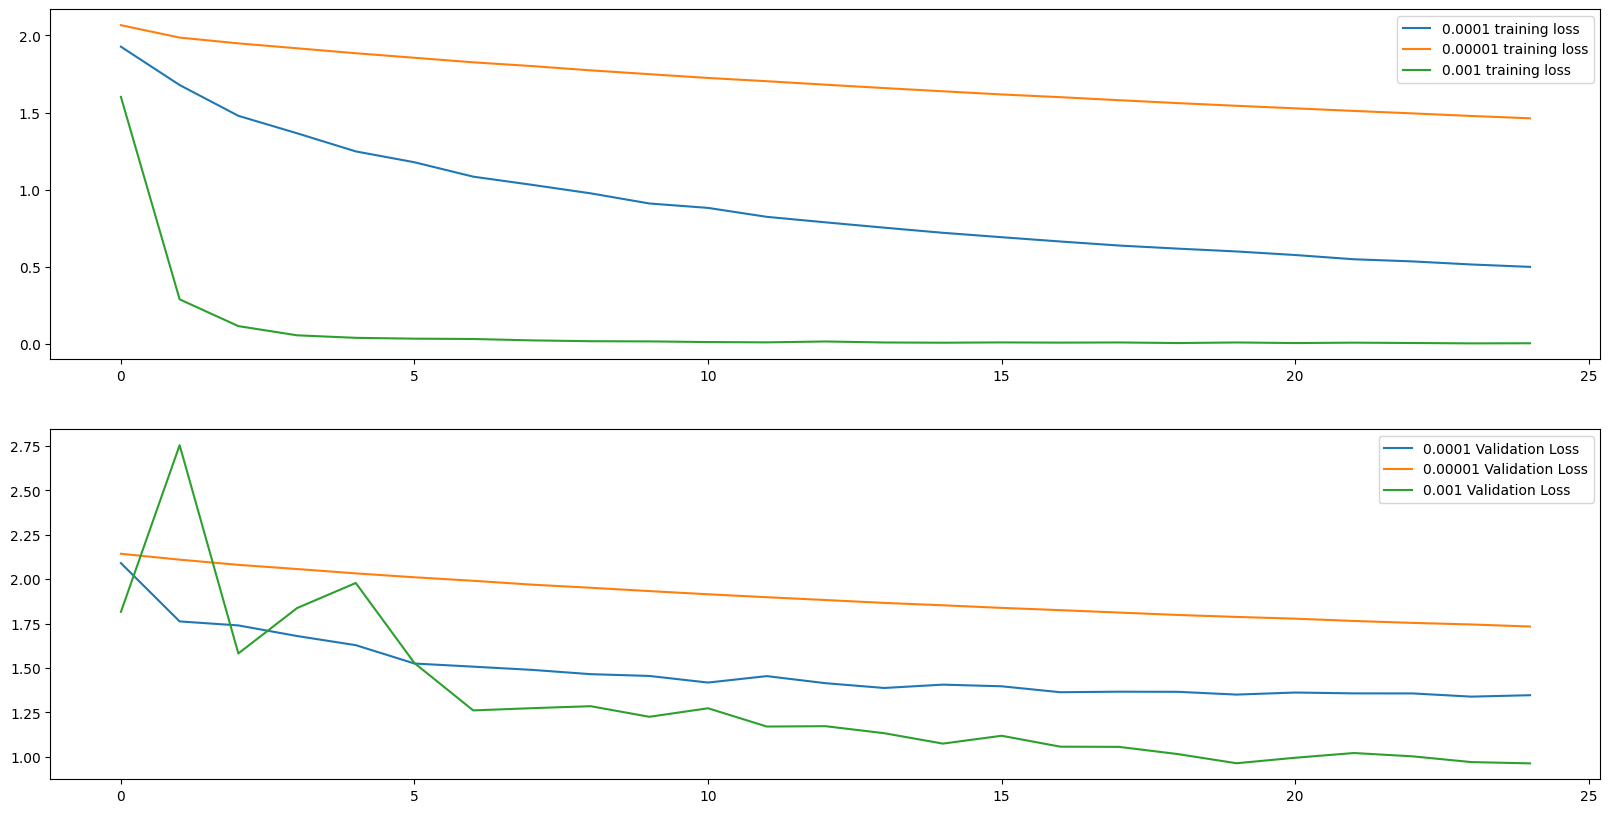

In [8]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history_1.history['loss'], label="0.0001 training loss")
ax.plot(history_2.history['loss'], label="0.00001 training loss")
ax.plot(history_3.history['loss'], label="0.001 training loss")
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.plot(history_1.history['val_loss'], label="0.0001 Validation Loss")
ax.plot(history_2.history['val_loss'], label="0.00001 Validation Loss")
ax.plot(history_3.history['val_loss'], label="0.001 Validation Loss")
ax.legend()




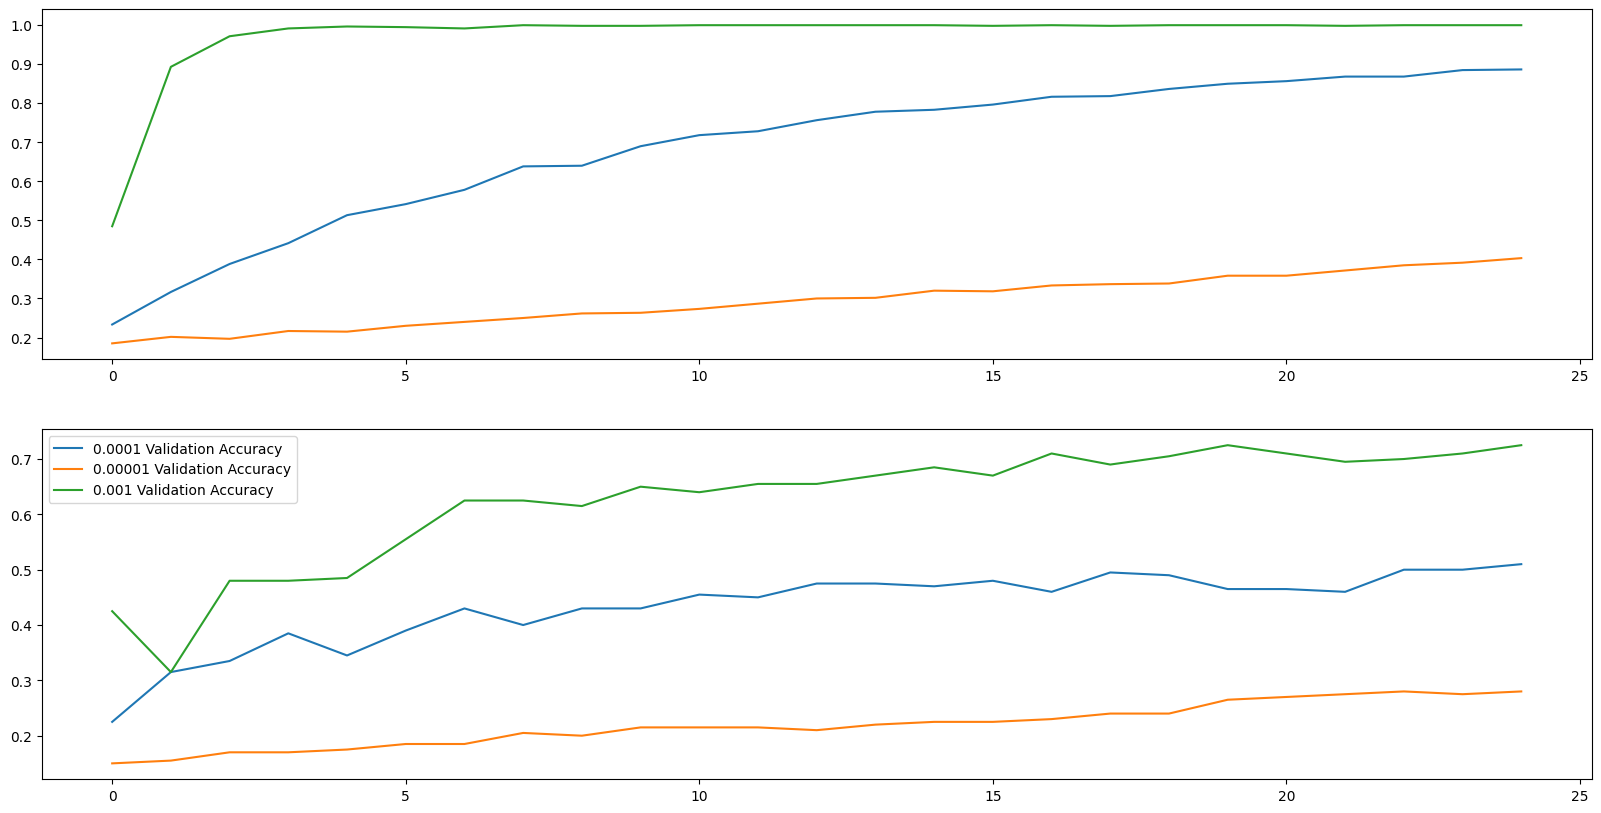

In [9]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history_1.history['accuracy'], label="0.0001 Training Accuracy")
ax.plot(history_2.history['accuracy'], label="0.00001 Training Accuracy")
ax.plot(history_3.history['accuracy'], label="0.001 Training Accuracy")
ax = fig.add_subplot(2, 1, 2)
ax.plot(history_1.history['val_accuracy'], label="0.0001 Validation Accuracy")
ax.plot(history_2.history['val_accuracy'], label="0.00001 Validation Accuracy")
ax.plot(history_3.history['val_accuracy'], label="0.001 Validation Accuracy")
ax.legend()


In [10]:
base_model1 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model1.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model1.output)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model1.input, outputs=x)
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_4 = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
19/19 [==============================] - 14s 669ms/step - loss: 17.5467 - accuracy: 0.2583 - val_loss: 12.0042 - val_accuracy: 0.3350
Epoch 2/25
19/19 [==============================] - 13s 679ms/step - loss: 5.4880 - accuracy: 0.5683 - val_loss: 10.0406 - val_accuracy: 0.4350
Epoch 3/25
19/19 [==============================] - 13s 678ms/step - loss: 2.3216 - accuracy: 0.7650 - val_loss: 6.1136 - val_accuracy: 0.4800
Epoch 4/25
19/19 [==============================] - 13s 671ms/step - loss: 0.8346 - accuracy: 0.8617 - val_loss: 6.4162 - val_accuracy: 0.5150
Epoch 5/25
19/19 [==============================] - 14s 750ms/step - loss: 0.3093 - accuracy: 0.9350 - val_loss: 7.5170 - val_accuracy: 0.4450
Epoch 6/25
19/19 [==============================] - 16s 830ms/step - loss: 0.3615 - accuracy: 0.9283 - val_loss: 5.0929 - val_accuracy: 0.5600
Epoch 7/25
19/19 [==============================] - 16s 850ms/step - loss: 0.1892 - accuracy: 0.9583 - val_loss: 5.4857 - val_accuracy: 0.5

In [11]:
base_model2 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model2.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model2.output)
x = Dense(5, activation='softmax')(x)
new_model = Model(inputs=base_model2.input, outputs=x)
optimizer = SGD(learning_rate=0.001, momentum=0.2, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_5 = new_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
19/19 [==============================] - 15s 700ms/step - loss: 12.3314 - accuracy: 0.2433 - val_loss: 12.3248 - val_accuracy: 0.2300
Epoch 2/25
19/19 [==============================] - 13s 689ms/step - loss: 9.3282 - accuracy: 0.3183 - val_loss: 12.2978 - val_accuracy: 0.2000
Epoch 3/25
19/19 [==============================] - 13s 718ms/step - loss: 3.9118 - accuracy: 0.5417 - val_loss: 6.2208 - val_accuracy: 0.2950
Epoch 4/25
19/19 [==============================] - 14s 739ms/step - loss: 3.1252 - accuracy: 0.5583 - val_loss: 2.6725 - val_accuracy: 0.4800
Epoch 5/25
19/19 [==============================] - 14s 724ms/step - loss: 2.9092 - accuracy: 0.5767 - val_loss: 6.8775 - val_accuracy: 0.3250
Epoch 6/25
19/19 [==============================] - 14s 770ms/step - loss: 1.5304 - accuracy: 0.6867 - val_loss: 2.1232 - val_accuracy: 0.5550
Epoch 7/25
19/19 [==============================] - 13s 717ms/step - loss: 0.3677 - accuracy: 0.8783 - val_loss: 2.5633 - val_accuracy: 0.4

In [12]:
base_model3 = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model3.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model3.output)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model3.input, outputs=x)
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_6 = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
19/19 [==============================] - 15s 701ms/step - loss: 20.1075 - accuracy: 0.2467 - val_loss: 21.7565 - val_accuracy: 0.2400
Epoch 2/25
19/19 [==============================] - 13s 681ms/step - loss: 17.1002 - accuracy: 0.4567 - val_loss: 15.6969 - val_accuracy: 0.4700
Epoch 3/25
19/19 [==============================] - 14s 729ms/step - loss: 8.3805 - accuracy: 0.5883 - val_loss: 8.7648 - val_accuracy: 0.5200
Epoch 4/25
19/19 [==============================] - 14s 751ms/step - loss: 5.0741 - accuracy: 0.7050 - val_loss: 9.7717 - val_accuracy: 0.5200
Epoch 5/25
19/19 [==============================] - 16s 854ms/step - loss: 2.0555 - accuracy: 0.8500 - val_loss: 10.1113 - val_accuracy: 0.4950
Epoch 6/25
19/19 [==============================] - 15s 796ms/step - loss: 1.0313 - accuracy: 0.8917 - val_loss: 9.8427 - val_accuracy: 0.4950
Epoch 7/25
19/19 [==============================] - 14s 732ms/step - loss: 0.2088 - accuracy: 0.9667 - val_loss: 7.2565 - val_accuracy: 0

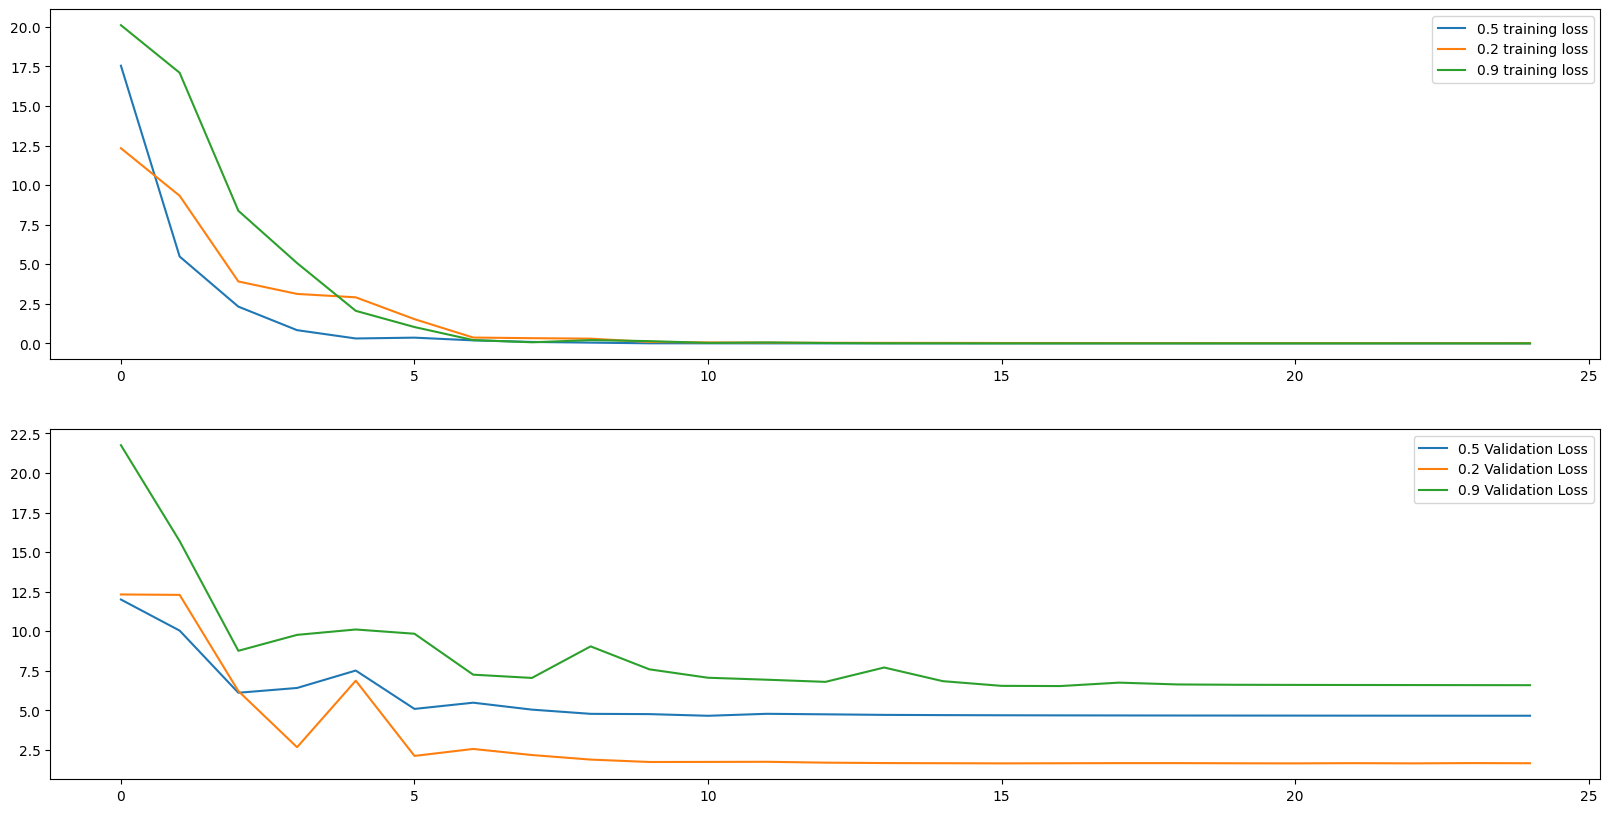

In [14]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history_4.history['loss'], label="0.5 training loss")
ax.plot(history_5.history['loss'], label="0.2 training loss")
ax.plot(history_6.history['loss'], label="0.9 training loss")
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(history_4.history['val_loss'], label="0.5 Validation Loss")
ax.plot(history_5.history['val_loss'], label="0.2 Validation Loss")
ax.plot(history_6.history['val_loss'], label="0.9 Validation Loss")
ax.legend()



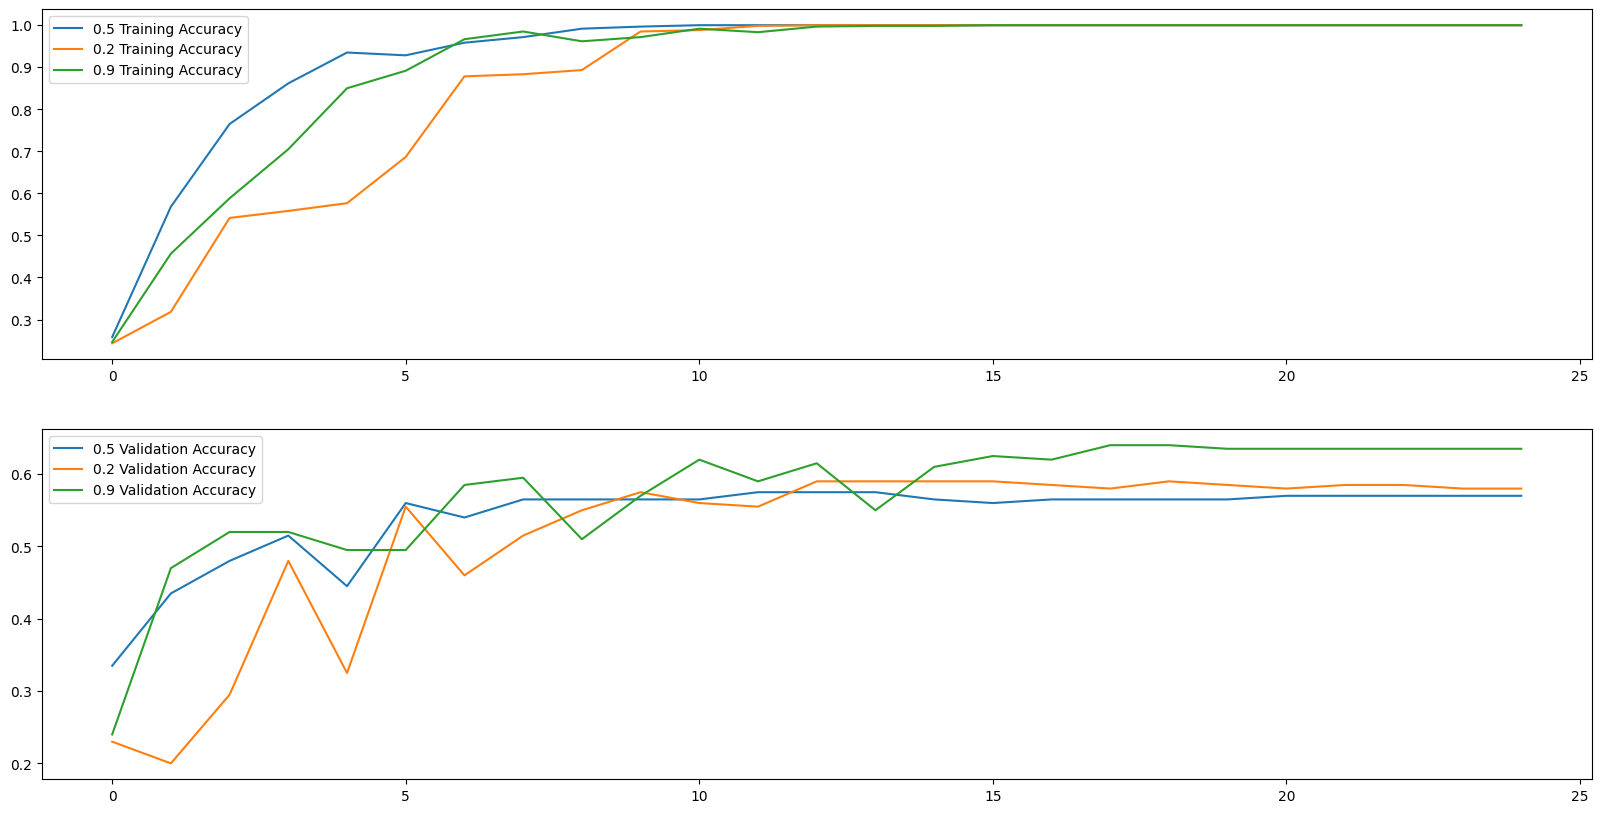

In [15]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history_4.history['accuracy'], label="0.5 Training Accuracy")
ax.plot(history_5.history['accuracy'], label="0.2 Training Accuracy")
ax.plot(history_6.history['accuracy'], label="0.9 Training Accuracy")
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(history_4.history['val_accuracy'], label="0.5 Validation Accuracy")
ax.plot(history_5.history['val_accuracy'], label="0.2 Validation Accuracy")
ax.plot(history_6.history['val_accuracy'], label="0.9 Validation Accuracy")
ax.legend()

Section 3: Prediction and Visualization

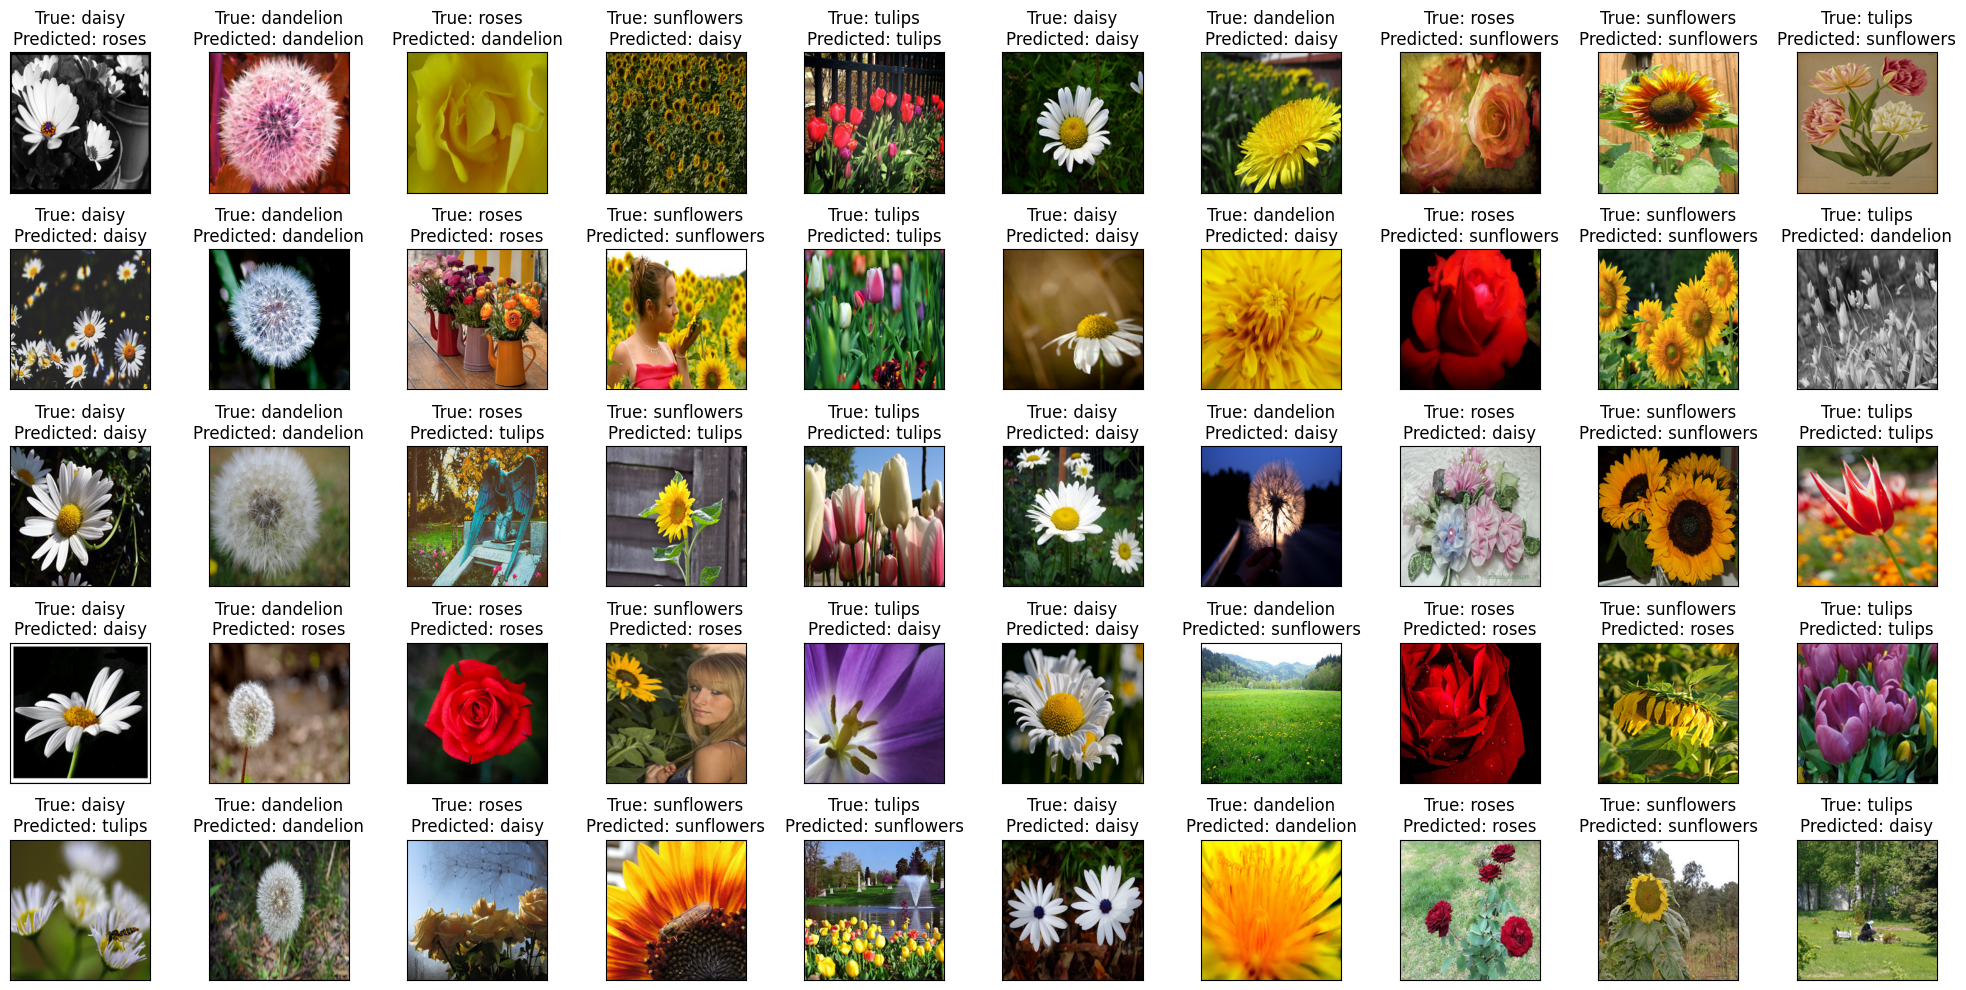

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the first 10 results in X_test
y_pred = model.predict(X_test)
y_pred_labels = [list(CATEGORIES.keys())[list(CATEGORIES.values()).index(np.argmax(p))] for p in y_pred]

# Convert the one-hot encoded true labels to labels
y_true_labels = list(y_test)
true_labels = []
for label in y_true_labels:
    true_labels.append(list(CATEGORIES.keys())[list(CATEGORIES.values()).index(np.argmax(label))])

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"True: {true_labels[i]}\nPredicted: {y_pred_labels[i]}")

plt.tight_layout()
plt.show()
